# Algorithmic state abstraction

In the previous notebook, we saw that not all variables in the state space contribute equally to the value function. Some combinations of variables preserve the value function almost perfectly, while others lead to large deviations. Importanty, in order to determine which heuristic abstraction is the best (i.e. leads to the strongest state space reduction while minimizing return loss), we need to apply dynamic programming to each one and compute its optimal return to compare to that of the ground MDP. This is obviously not a very useful method, as it requires computing dynamic programming of the full MDP as well as that of all other abstracted MDPs to then select a given task representation. In that case, we might a well just compute the optimal solution on the full MDP and be done with it. However, from the concept of state equivalence, we know that if two states share exactly the same transition probabilities and immediate rewards, merging them preserves the optimal value function with no loss. The bisimulation method formalizes this equivalence, but its limitation is that it only allows merging exactly equivalent states—preventing further compression of the MDP.

This naturally raises the question of whether there exists a middle ground between strict bisimulation and purely heuristic abstraction: can we merge approximately equivalent states—those with similar but not identical transition and reward structures—without heavily distorting the value function? Intuitively, if exact equivalence guarantees perfect preservation, near-equivalence should yield good approximations. Indeed, several approaches exploit this idea, performing abstraction in a guided way using the transition and reward structure of the MDP <a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1) <a name="bib_ref-2"></a>[<sup>[2]</sup>](#bib_ref-2) <a name="bib_ref-3"></a>[<sup>[3]</sup>](#bib_ref-3). Bisimulation can thus be seen as the most stringent case of a broader family of algorithmic state abstraction methods.

## Metric for state abstraction
Most of the algorithmic literature focuses on designing specific procedures to achieve a particular level of abstraction efficiently—e.g., algorithms that simplify the MDP while preserving the probability of reaching certain states within a given horizon. In contrast, our goal is not to specify which algorithm the brain might implement, but to test whether and how much abstraction occurs at all. If the brain reduces the complexity of its decision problem, it likely trades off computational cost against accuracy in expected return. Following the logic of bisimulation, the optimal way to do this is to aggregate states with similar transition and reward functions—states that “behave” similarly enough to not disrupt the resulting value function.

This is why we use the bisimulation metric proposed by Ferns and colleagues <a name="bib_ref-4"></a>[<sup>[4]</sup>](#bib_ref-4) <a name="bib_ref-5"></a>[<sup>[5]</sup>](#bib_ref-5). Rather than yielding one specific abstraction, this metric defines a continuous distance between states based on their transition and reward similarity. By setting a distance threshold $\epsilon$, we can aggregate all states within $\epsilon$ distance of each other. Small $\epsilon$ values correspond to fine-grained, nearly exact models (little abstraction), while large $\epsilon$ values yield coarser, more compact models (strong abstraction). Thus, instead of committing to one algorithmic level of simplification, the bisimulation metric provides a principled way to parameterize the entire continuum of possible abstractions, from the ground MDP to a single aggregated state.

We can simply compute the (approximated) bisimulation distance <a name="bib_ref-4"></a>[<sup>[4]</sup>](#bib_ref-4) for each pairs of states in our state space:

In [6]:
import numpy as np
import os
from stabst.utils import abstract2ground_value, summarize_state_classes, plot_state_matrix
from stabst.MarkovDecisionProcess import MDP
from stabst.TaskConfig import LimitedEnergyTask
import matplotlib.pyplot as plt
# %matplotlib widget
from tqdm import tqdm

# Create the task and its parameters (transition probability, reward...):
task = LimitedEnergyTask(O=[1, 2, 3, 4], p_offer=[1/4] * 4)
task.build()

# Create ground MDP and compute solution for later reference:
task_mdp = MDP(task.states, task.tp, task.r, s2i=task.s2i)
V_ground, Q_ground = task_mdp.backward_induction()
R_ground = task_mdp.expected_return(task_mdp.greedy_policy(Q_ground), initial_energy=3)

# Compute pairwise distances:
task.build()
# Compute pairwise distances:
if not os.path.isfile('../data/bids/limited_energy/derivatives/state_abstraction/bisimulation_distance_matrix.npy'):
    distances_matrix = task_mdp.bisim_metric(gamma=0.99, tol=1e-3, njobs=-1, max_iters=1000)
    distances_matrix = distances_matrix / np.max(distances_matrix)
    if not os.path.isdir("../data/bids/limited_energy/derivatives/state_abstraction"):
        os.makedirs("../data/bids/limited_energy/derivatives/state_abstraction")
    np.save('../data/bids/limited_energy/derivatives/state_abstraction/bisimulation_distance_matrix.npy', distances_matrix)
else:
    distances_matrix = np.load('../data/bids/limited_energy/derivatives/state_abstraction/bisimulation_distance_matrix.npy')

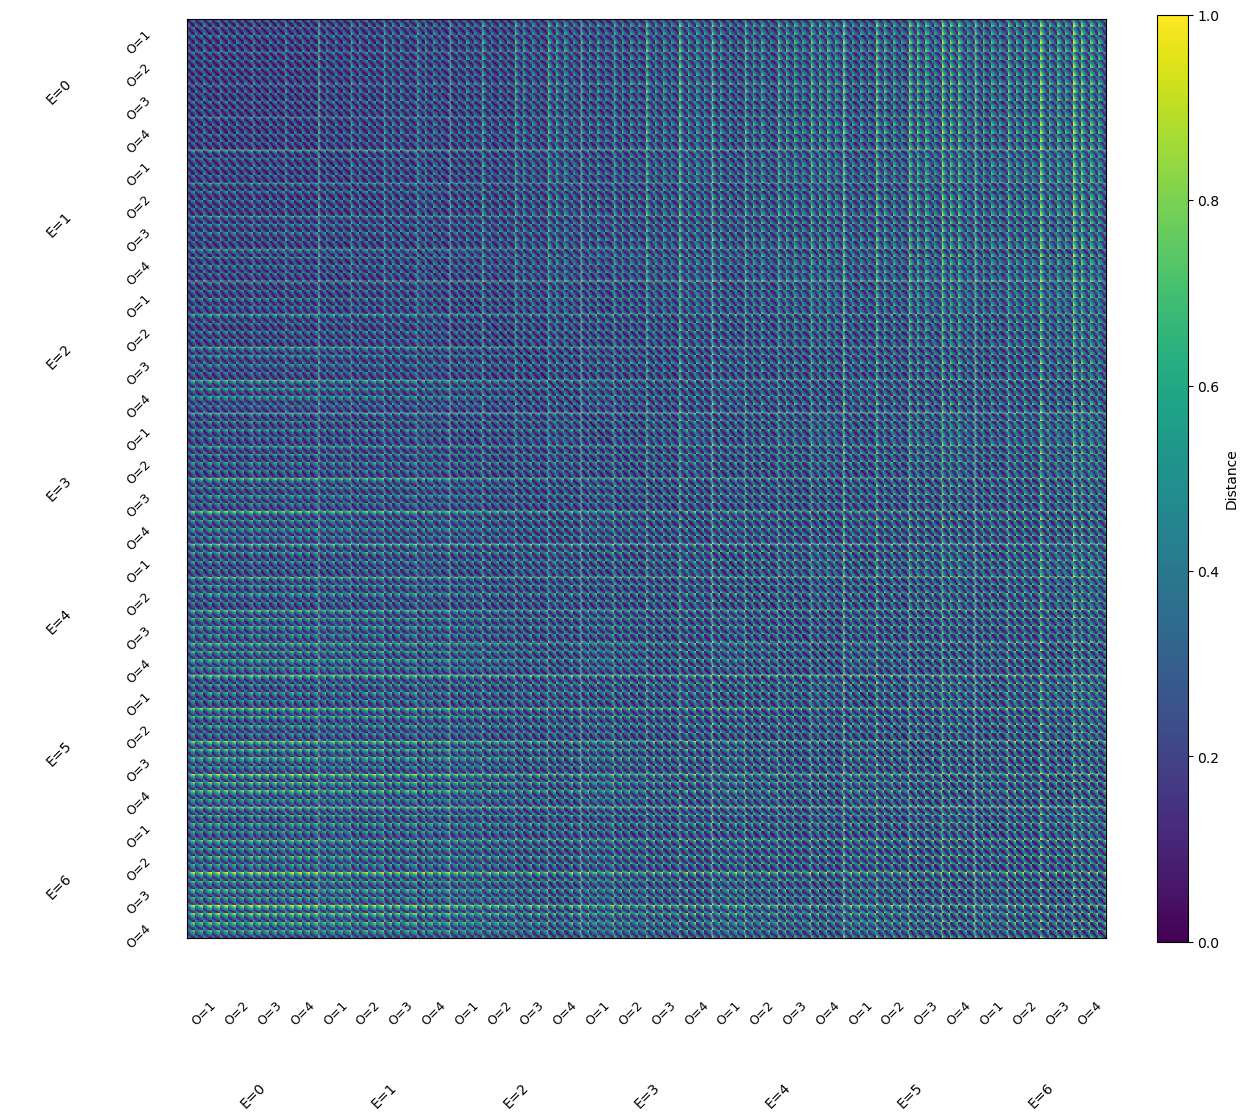

In [7]:
# Plot the distance matrix:
plot_state_matrix(distances_matrix, task.states, feature_names=["E", "O", "CC", "FC", "T"], depth=2)
plt.show()

Now that we have computed the pairwise distances between all state pairs, we can try to find "clusters" of states, i.e. classes, which are separated by a maximum distance that we can define. Importantly, unlike in the exact bisimulation were we could simply look for all groups of states that were equivalent, creating clusters is a bit more involved in that case. Let's say we have three states $s_1$, $s_2$, and $s_3$, and the following distances between them: $d(s_1, s_2) = 0.1$, $d(s_2, s_3) = 0.1$. We would be tempted to put all three states in the same cluster, but we could be lumping states that are distant from each other if $d(s_1, s_3) > 0.1$. 

When creating classes based on a distance $\epsilon$, we want to make sure that the distance that separates all the states within a class is $\le\epsilon$. To do so, we will use hierarchical clustering with complete linkage. This is a clustering technique that generates clusters iteratively by combining clusters based on the maximal distance between pairs of units within clusters <a name="bib_ref-6"></a>[<sup>[6]</sup>](#bib_ref-6). Below, we generate abstract MDP at various $\epsilon$, and print the resulting states clusters:

In [8]:
# Get optimal return from ground MDP
R_ground = task_mdp.expected_return(task_mdp.greedy_policy(Q_ground), initial_energy=3)
# Get return from ground MDP with random policy to use as floor
R_random_relative = 1 - (R_ground - task_mdp.expected_return(np.zeros((len(task_mdp.states), 2)) + 0.5, initial_energy=3))/R_ground
# Get the unique abstraction distances:
unique_dist = np.unique(np.round(distances_matrix, decimals=3))
# Prepare lists:
abstraction_distance, abstraction_size, abstraction_return_accuracy = [], [], []
variables_names = ["energy", "offers", "current cost", "future cost", "t"]

# Loop through every 10 distances:
n_states = 0
for eps in np.arange(0, 1, 0.001): #unique_dist:
    # Generate abstracted MDP at that level of abstraction:
    abstract_mdp, state_classes, class_of_state = task_mdp.distance_reduce_mdp(eps, distance_matrix=distances_matrix)
    # Solve the MDP:
    V_R, Q_R = abstract_mdp.backward_induction()
    # Print the summary:
    if eps > 0 and np.abs(len(abstract_mdp.states) - n_states) >= 10:
        n_states = len(abstract_mdp.states)
        summarize_state_classes(state_classes, eps, Q_R[:, 1] - Q_R[:, 0], variables_names, max_classes=40)

    # Project back to Ground space:
    V_from_abstract, Q_from_abstract = abstract2ground_value(class_of_state, V_R, Q_R)
    # Compute the expected return:
    abstraction_return_accuracy.append(1 - (R_ground - task_mdp.expected_return(task_mdp.greedy_policy(Q_from_abstract), initial_energy=3))/R_ground)
    abstraction_distance.append(eps)
    abstraction_size.append(len(state_classes))

# Convert to numpy arrays:
abstraction_size = np.array(abstraction_size)
abstraction_distance = np.array(abstraction_distance)
abstraction_return_accuracy = np.array(abstraction_return_accuracy)

AGGREGATION SUMMARY AT EPS=0.001
# classes                : 554
# states total           : 1456
class size - mean / std  : 2.63 / 7.32
class size - min / max   : 1 / 128

GLOBAL STATE-SPACE STATS (over all states):
--------------------------------------------------------------------------------
      energy: min=   0.000  max=   6.000  range=   6.000
      offers: min=   1.000  max=   4.000  range=   3.000
current cost: min=   1.000  max=   2.000  range=   1.000
 future cost: min=   1.000  max=   2.000  range=   1.000
           t: min=   1.000  max=  13.000  range=  12.000

AVERAGE WITHIN-CLASS RANGE PER DIMENSION:
(relative = within-class range / global range)
--------------------------------------------------------------------------------
      energy: mean_range=   0.167  relative= 0.028
      offers: mean_range=   0.717  relative= 0.239
current cost: mean_range=   0.887  relative= 0.887
 future cost: mean_range=   0.108  relative= 0.108
           t: mean_range=   0.017  relative=

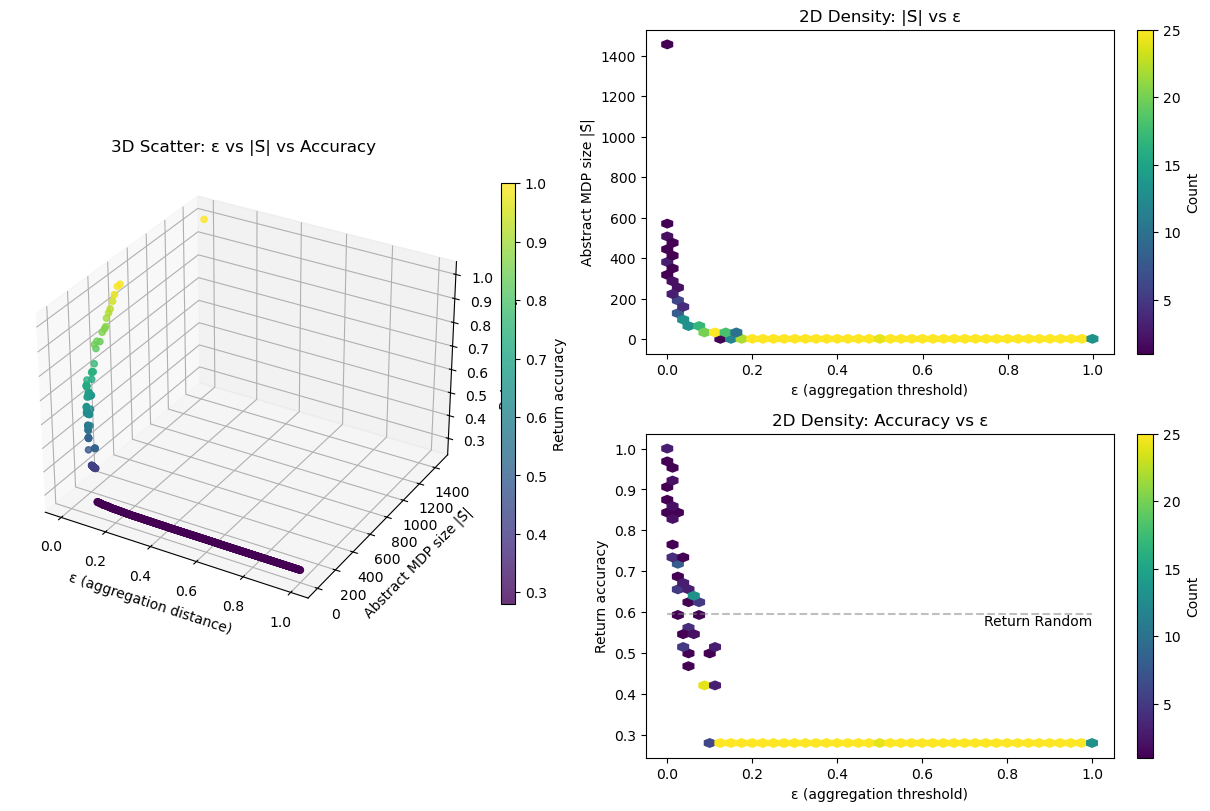

In [9]:
# Layout: 3D on the left spanning rows, two hexbin plots on the right
fig, axes = plt.subplot_mosaic(
    [
        ["three_d", "hex_size"],
        ["three_d", "hex_acc"],
    ],
    figsize=(12, 8),
    constrained_layout=True,   # handles spacing nicely
)

# ---- Turn the left axis into a 3D axis
ax2d = axes["three_d"]
sspec = ax2d.get_subplotspec()
ax2d.remove()
ax3d = fig.add_subplot(sspec, projection="3d")

# 3D scatter: ε vs |S̄| vs accuracy
sc = ax3d.scatter(
    abstraction_distance,
    abstraction_size,
    abstraction_return_accuracy,
    c=abstraction_return_accuracy,
    alpha=0.8,
)

ax3d.set_xlabel("ε (aggregation distance)")
ax3d.set_ylabel("Abstract MDP size |S̄|")
ax3d.set_zlabel("Return accuracy")
ax3d.set_title("3D Scatter: ε vs |S̄| vs Accuracy")

# small, slim colorbar for the 3D plot
fig.colorbar(
    sc,
    ax=ax3d,
    label="Return accuracy",
    pad=0.05,
    fraction=0.03,   # overall size
    aspect=30,       # thin bar
)

# ---- Upper-right hexbin: ε vs |S̄|
ax1 = axes["hex_size"]
hb1 = ax1.hexbin(
    abstraction_distance,
    abstraction_size,
    gridsize=40,
    mincnt=1,
    cmap="viridis",
)
ax1.set_xlabel("ε (aggregation threshold)")
ax1.set_ylabel("Abstract MDP size |S̄|")
ax1.set_title("2D Density: |S̄| vs ε")
fig.colorbar(hb1, ax=ax1, label="Count")

# ---- Lower-right hexbin: ε vs accuracy
ax2 = axes["hex_acc"]
hb2 = ax2.hexbin(
    abstraction_distance,
    abstraction_return_accuracy,
    gridsize=40,
    mincnt=1,
    cmap="viridis",
)
ax2.hlines(y=R_random_relative, xmin=0, xmax=1, linestyle='--', color='grey', alpha=0.5)
ax2.text(1, R_random_relative, 'Return Random', ha='right', va='top')
ax2.set_xlabel("ε (aggregation threshold)")
ax2.set_ylabel("Return accuracy")
ax2.set_title("2D Density: Accuracy vs ε")
fig.colorbar(hb2, ax=ax2, label="Count")

plt.show()


The top-left figure shows how the size of the abstracted MDP changes with the aggregation distance, $\epsilon$. As $\epsilon$ increases, more states are merged together, so the MDP becomes smaller—eventually collapsing into a single state when $\epsilon$ is large. The reduction happens exponentially, meaning that a small increase in $\epsilon$ can dramatically shrink the MDP.

The bottom-left figure shows how accurate the expected return from the abstracted MDP is compared to the optimal return obtained from the ground MDP. A value of 1 means the abstracted model performs as well as the optimal one, while 0 would mean no return at all (though in practice, even random policies yield some return). The key observation is that performance stays near optimal until $\epsilon$ reaches a fairly high value, meaning we can significantly compress the state space without sacrificing much reward. In fact, we can cut the MDP’s size by more than half and still perform almost optimally. This is important, because it suggests that reducing the MDP before solving it can dramatically simplify computation—a process that might reflect how the brain itself manages complex decision problems.

The top-right figure shows the mean squared error of the value function compared to the optimal one, as a function of $\epsilon$. Again, the value estimates remain close to optimal even for large $\epsilon$, confirming that strong abstraction barely affects performance.

The graph on the bottom right corner shows the value of representation derived from Ho et al. (2022) <a name="bib_ref-7"></a>[<sup>[7]</sup>](#bib_ref-7), which measures how efficient a abstracted MDP is by comparing its return to its size. A high VOR means the abstraction is both compact and effective. If the brain indeed performs this kind of abstraction, it might aim to find the $\epsilon$ that maximizes VOR—achieving the most useful compression without losing decision quality. This idea allows us to make concrete predictions about how abstraction levels might be chosen in neural computation.

## Predictions associated with bisimulation metric

The bisimulation metric provides a principled way to understand how the brain might simplify complex problems. It defines how states can be merged while preserving as much of the original MDP’s reward structure as possible. Because the metric is quantitative, it allows us to adjust the level of abstraction continuously—from fine-grained to very coarse—while maintaining control over the trade-off between precision and simplicity.

From this, several predictions follow. The first relates to VOR: if the brain seeks to balance accuracy and efficiency, it should choose abstractions corresponding to the $\epsilon$ that maximizes VOR. However, if cognitive resources are limited—say, the brain can only handle MDPs with a fixed number of states—then abstraction would not depend on VOR, but on reaching that computational limit. In that case, the brain would select $\epsilon$ so that the abstracted MDP fits within its processing capacity.

Alternatively, if computational capacity itself varies with factors like motivation or task difficulty, then the chosen $\epsilon$ would change accordingly. More motivated individuals, or those facing higher task rewards, would engage finer-grained representations (smaller $\epsilon$), since they can justify expending more cognitive resources for better precision.

## Decision values of state abstraction

We can plot the decision values at various $\epsilon$ to see what things look like:

<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_3632\2856502479.py:11: SyntaxWarning: invalid escape sequence '\e'
  task_mdp.plot_dv(Q_from_abstract[:, 1]-Q_from_abstract[:, 0], title=f'Decision value at $\epsilon={eps}$')


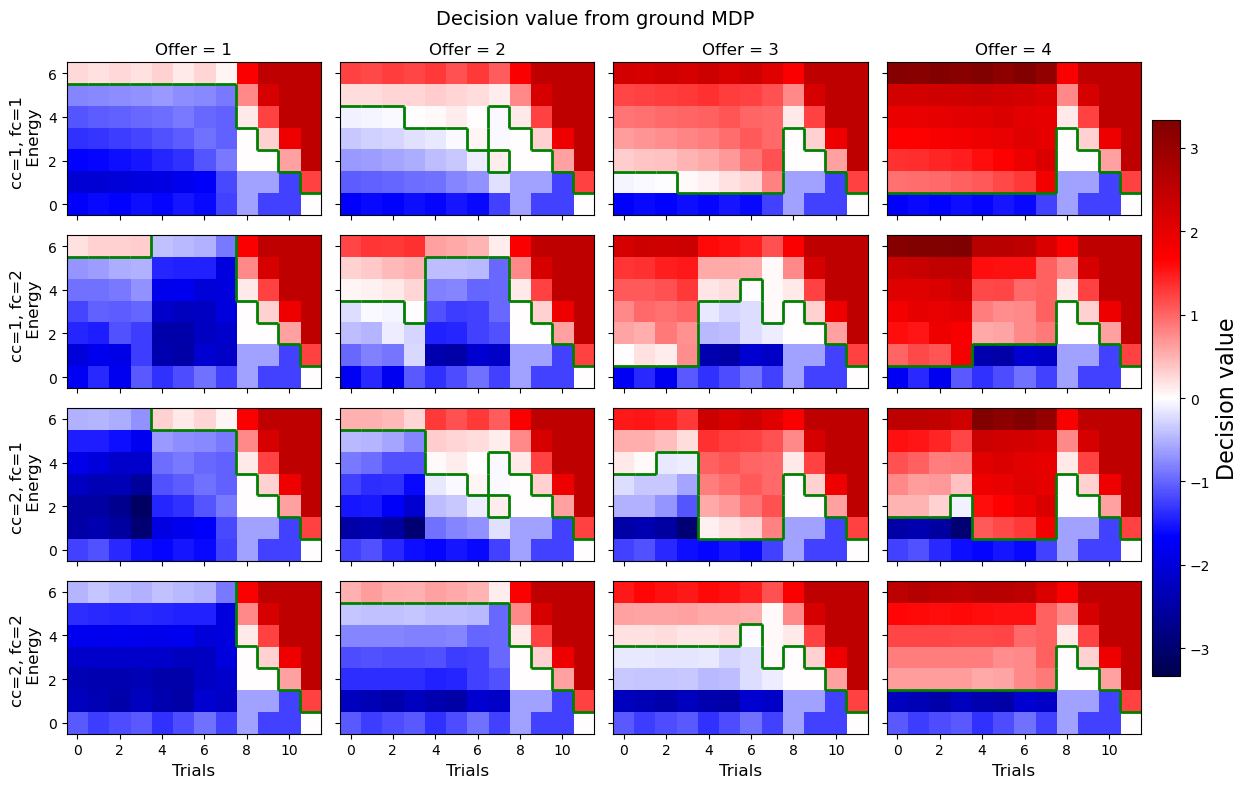

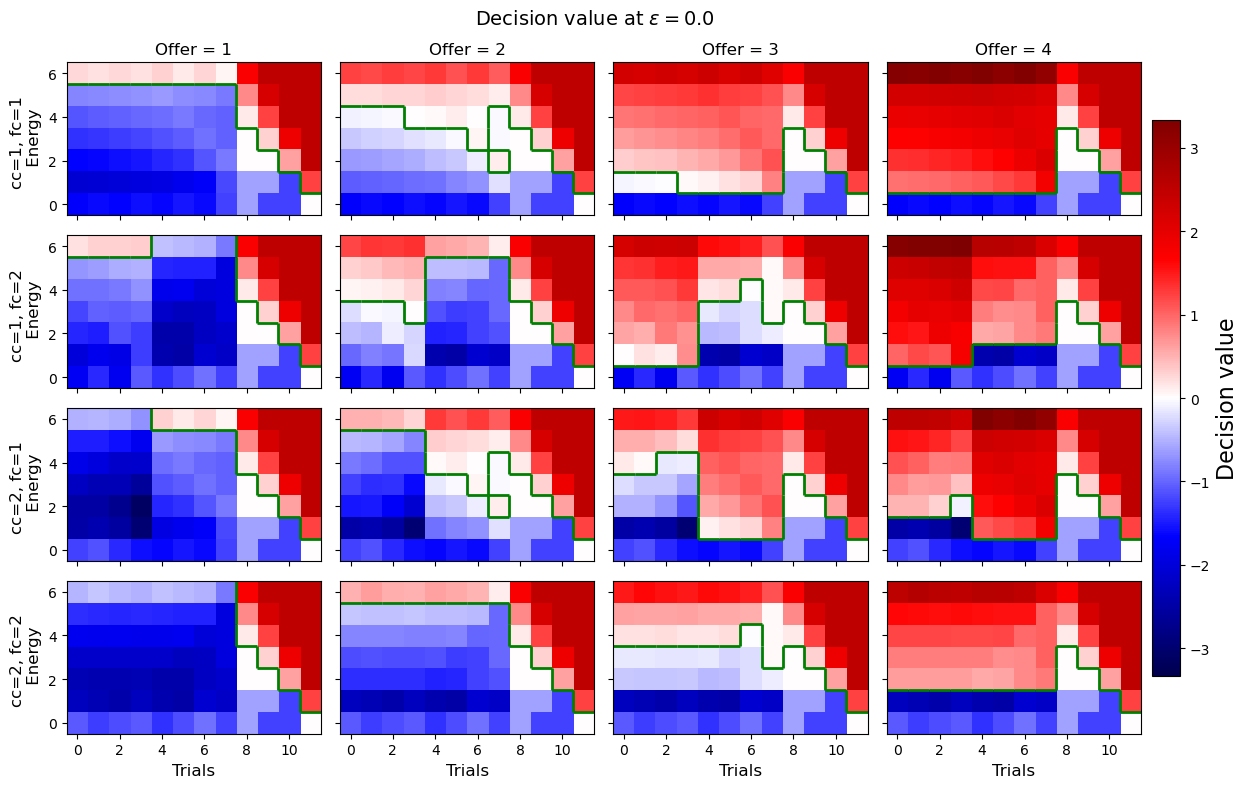

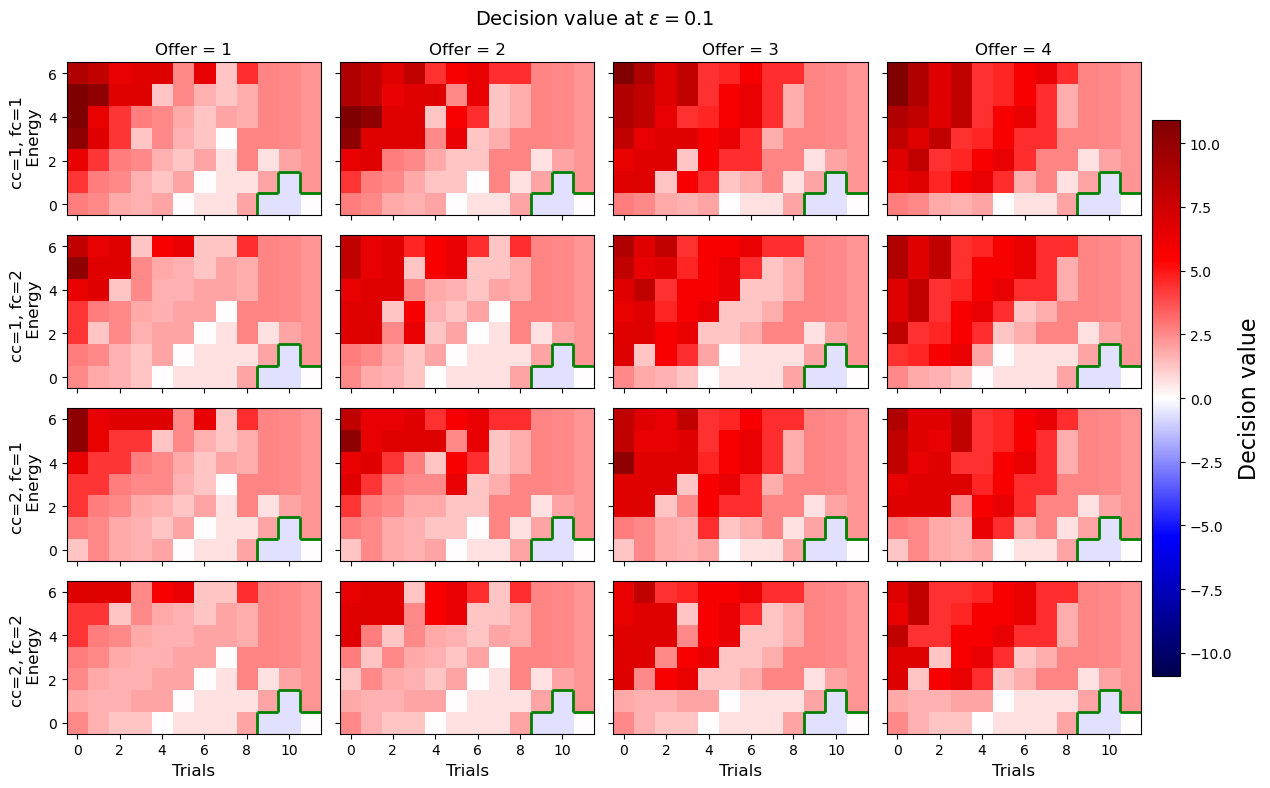

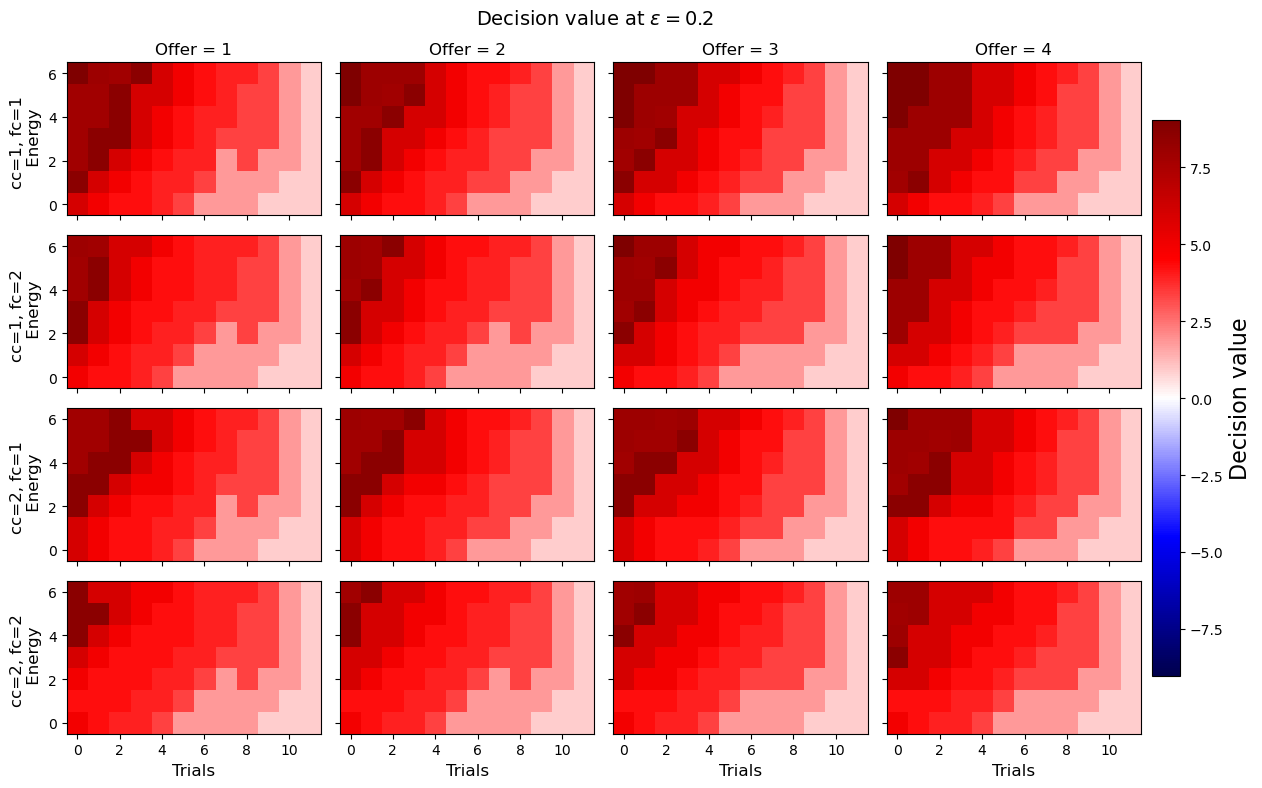

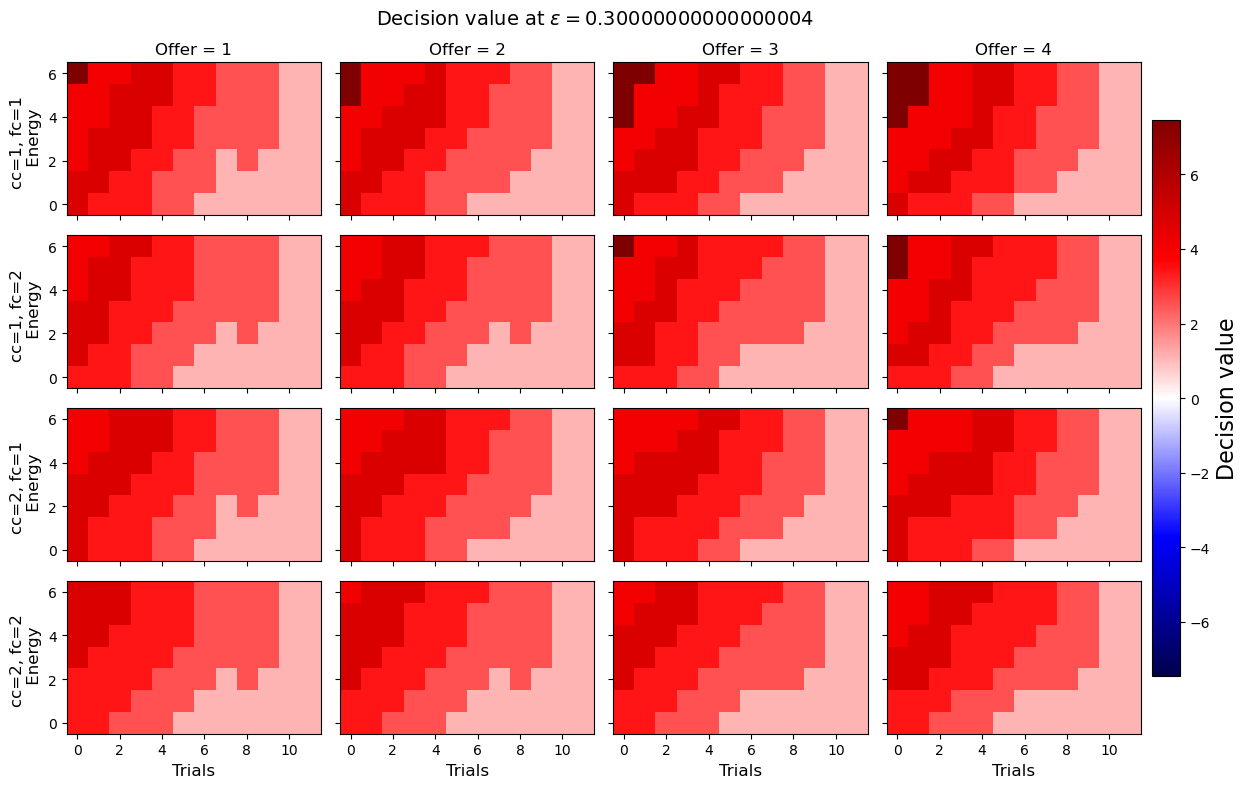

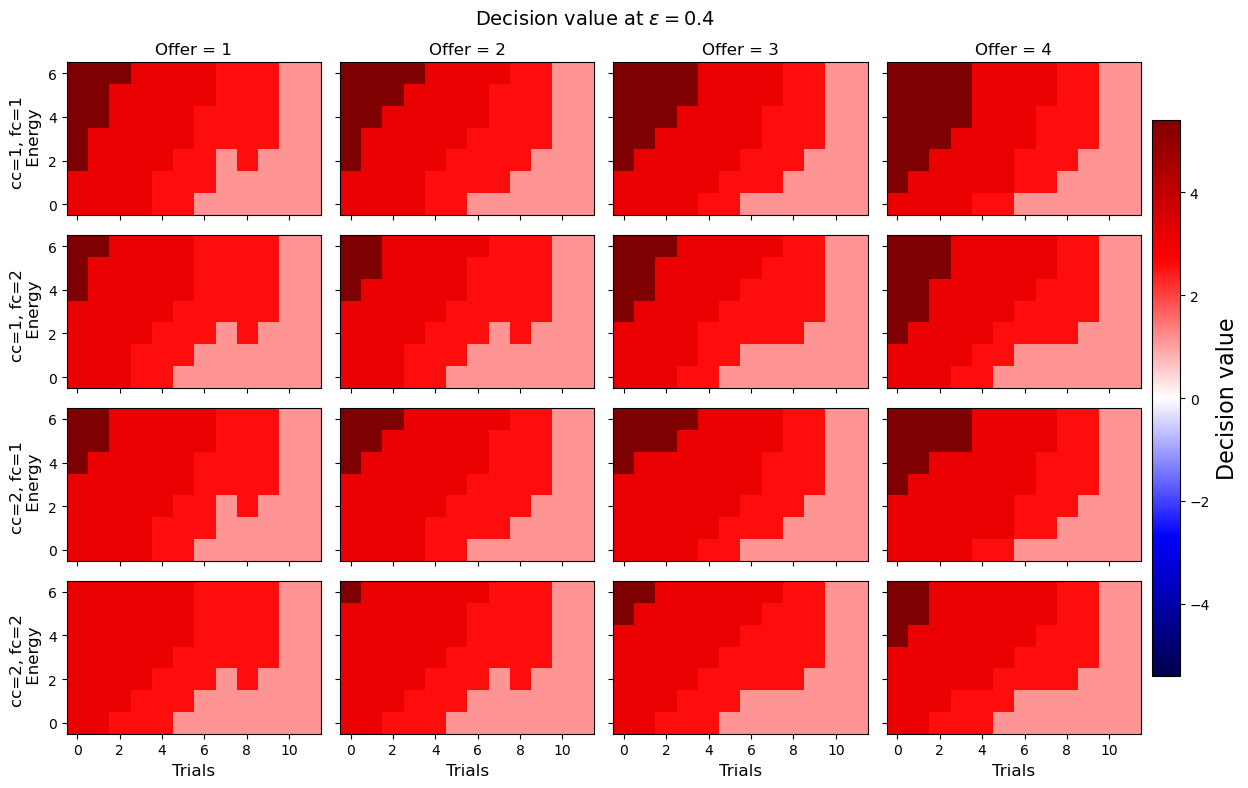

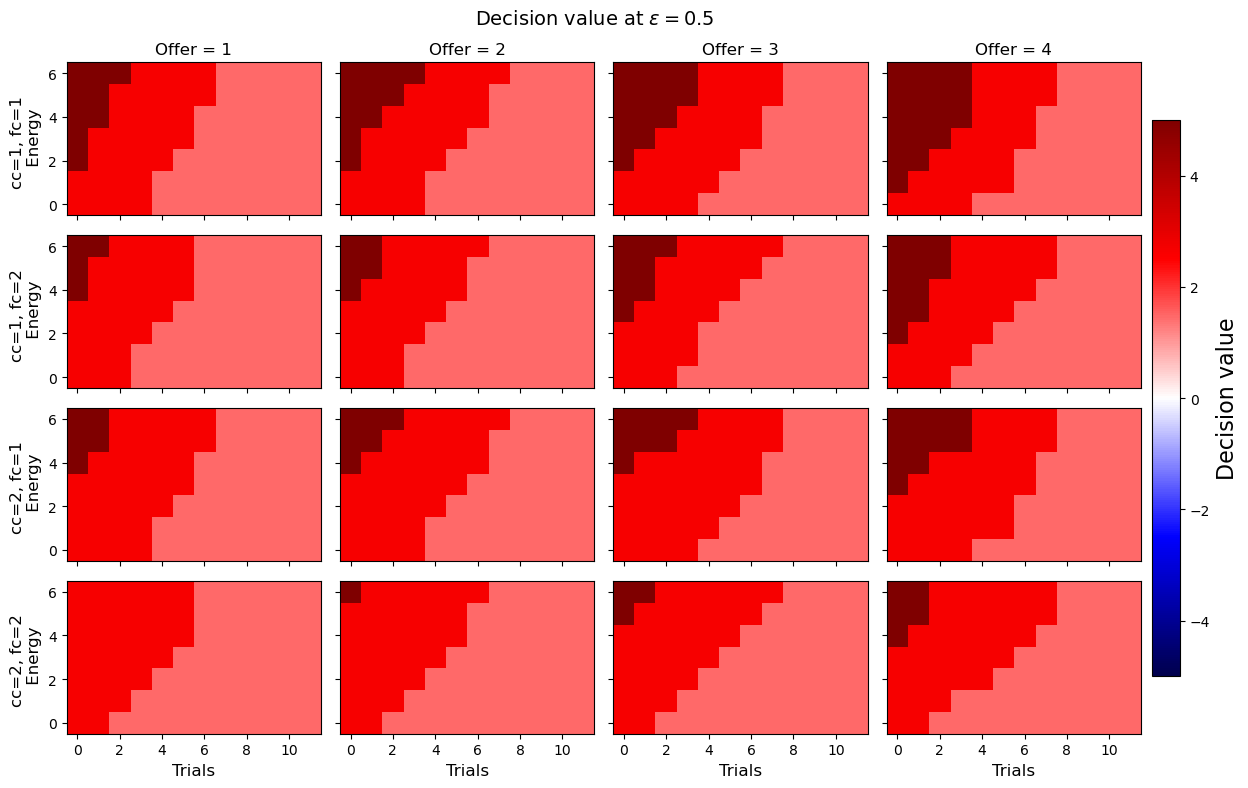

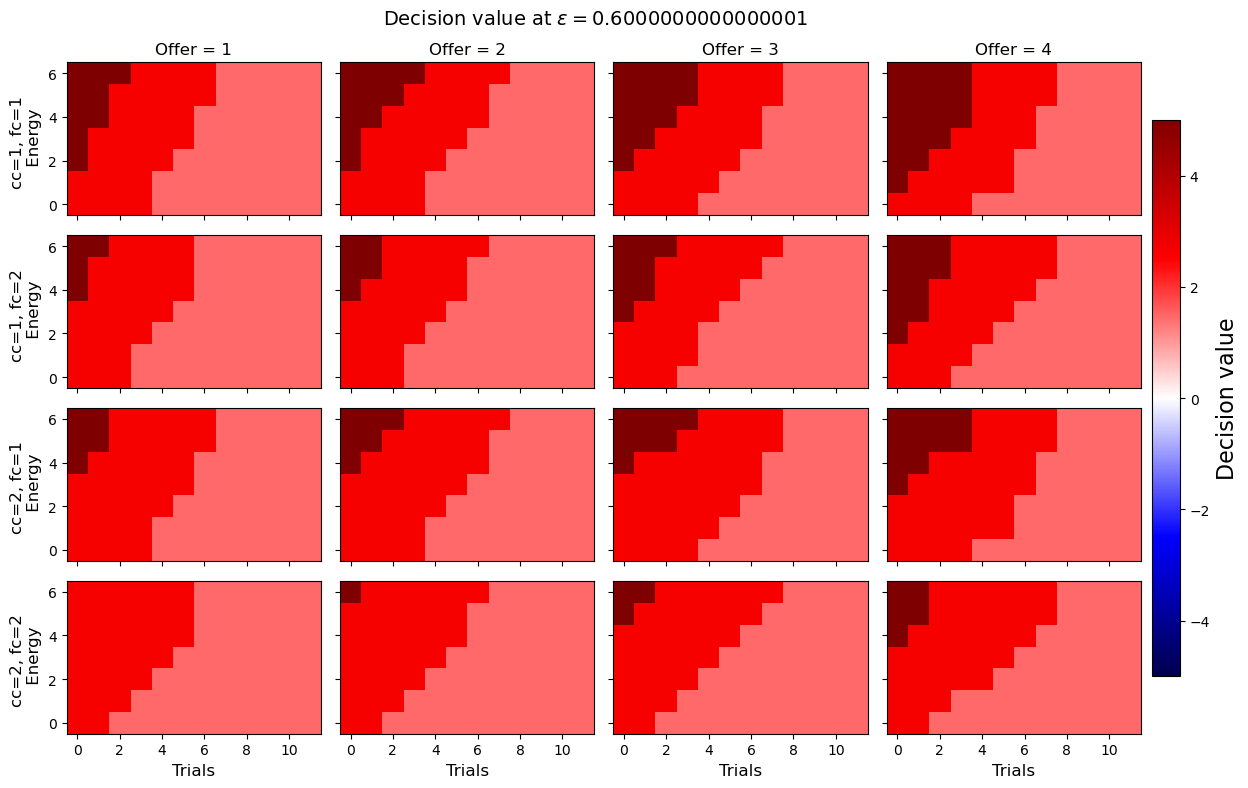

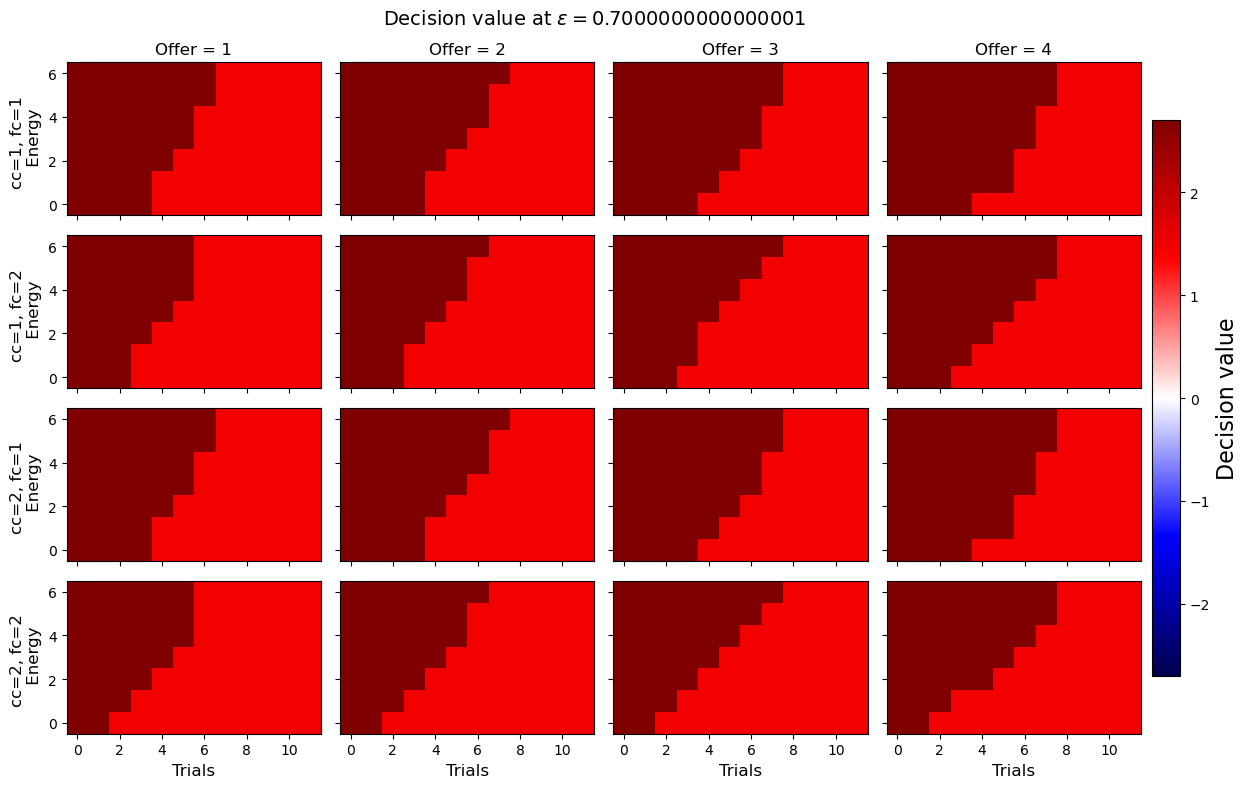

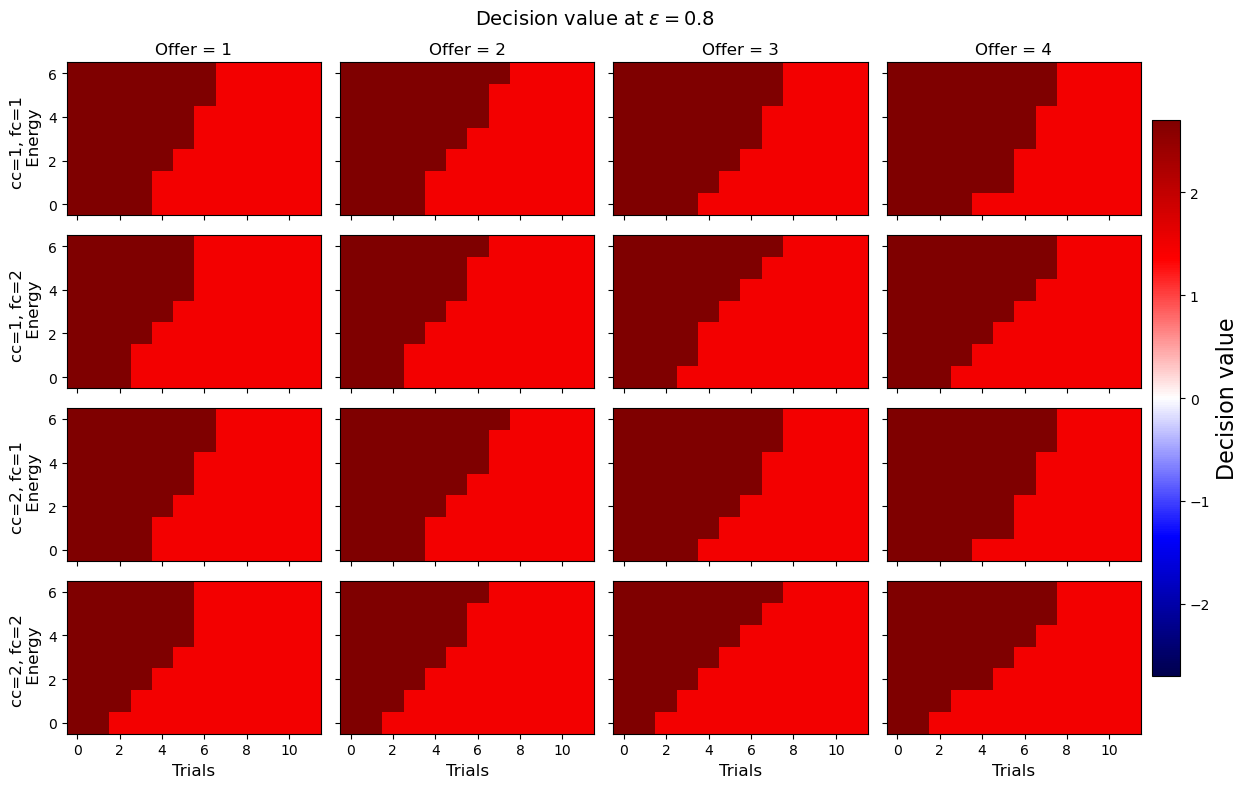

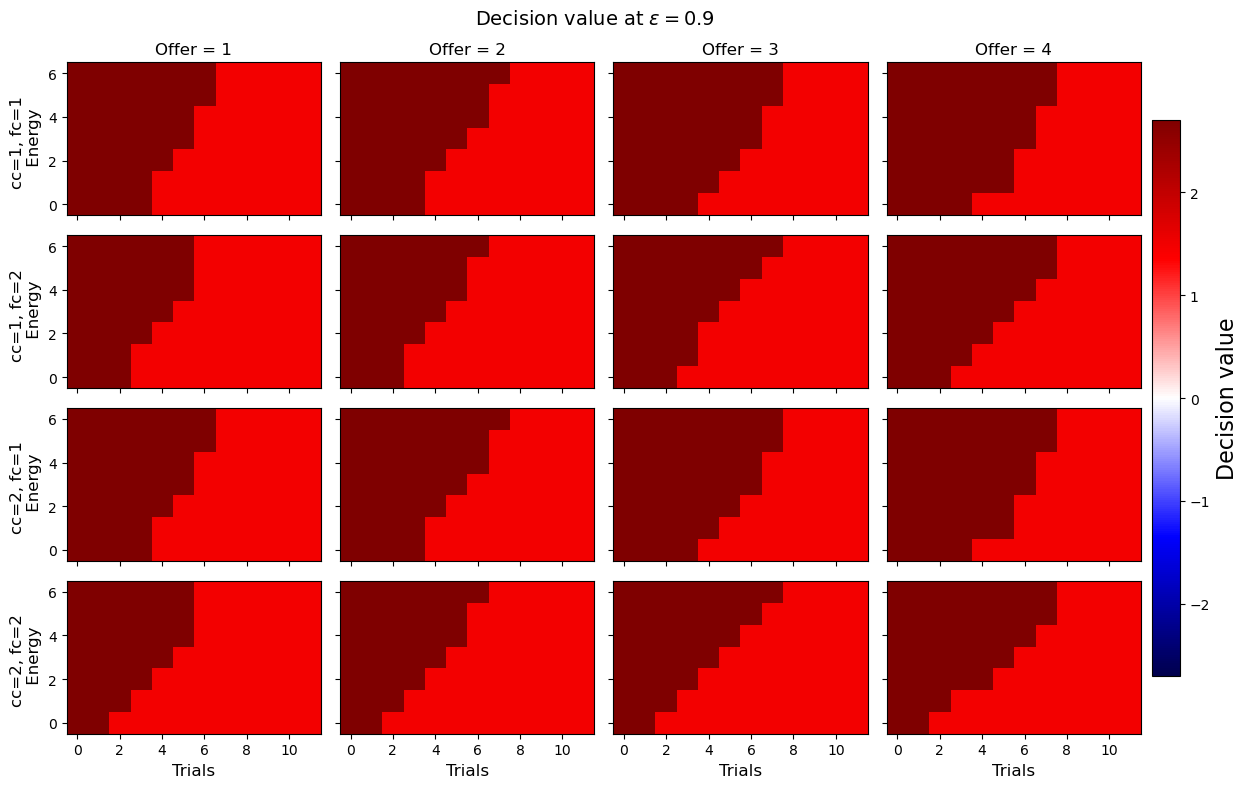

In [10]:
# Plot the decision values:
task_mdp.plot_dv(Q_ground[:, 1]-Q_ground[:, 0], title='Decision value from ground MDP')

for eps in np.arange(0, 1, 0.1):
    # Generate abstracted MDPs:
    abstract_mdp, state_classes, class_of_state = task_mdp.distance_reduce_mdp(eps, distance_matrix=distances_matrix)
    # Solve the MDP:
    V_R, Q_R = abstract_mdp.backward_induction()
    # Project back to ground space:
    V_from_abstract, Q_from_abstract = abstract2ground_value(class_of_state, V_R, Q_R)
    task_mdp.plot_dv(Q_from_abstract[:, 1]-Q_from_abstract[:, 0], title=f'Decision value at $\epsilon={eps}$')
plt.show()

# Bibliography
<a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1) Li, Lihong, Thomas J. Walsh, and Michael L. Littman. "Towards a unified theory of state abstraction for MDPs." AI&M 1.2 (2006): 3.

<a name="bib_ref-2"></a>[<sup>[2]</sup>](#bib_ref-2) Dean, T., & Givan, R. (1997, July). Model minimization in Markov decision processes. In AAAI/IAAI (pp. 106-111).

<a name="bib_ref-3"></a>[<sup>[3]</sup>](#bib_ref-3) Givan, R., Dean, T., & Greig, M. (2003). Equivalence notions and model minimization in Markov decision processes. Artificial intelligence, 147(1-2), 163-223.

<a name="bib_ref-4"></a>[<sup>[4]</sup>](#bib_ref-4) Ferns, N., Castro, P. S., Precup, D., & Panangaden, P. (2012). Methods for computing state similarity in Markov decision processes. arXiv preprint arXiv:1206.6836.

<a name="bib_ref-5"></a>[<sup>[5]</sup>](#bib_ref-5) Ferns, N., Panangaden, P., & Precup, D. (2004, July). Metrics for Finite Markov Decision Processes. In UAI (Vol. 4, pp. 162-169).

<a name="bib_ref-6"></a>[<sup>[6]</sup>](#bib_ref-6) Complete linkage clustering, wikipedia, https://en.wikipedia.org/wiki/Complete-linkage_clustering

<a name="bib_ref-7"></a>[<sup>[7]</sup>](#bib_ref-7) Ho, M. K., Abel, D., Correa, C. G., Littman, M. L., Cohen, J. D., & Griffiths, T. L. (2022). People construct simplified mental representations to plan. Nature, 606(7912), 129-136.